# Vuterbi on Zebra-Fish trajectories, tutorial of the M2 Cogmaster  course Machine Learning for Cognitive Science . Jorge Fernandez de Cossio Diaz, Simona Cocco 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# extract angles (put here the path to the file 'spontaneous_swim.mat')
alphas_spontaneous = h5py.File('spontaneous_swim.mat').get('Es/Angle')[:]

We consider zebrafish swimming freely in a bounded 2-dimensional area. The sequence of bout angles of individual trajectories will be modeled by an HMM. We suppose the fish can be in one of three states: F (forward bouts), L (turning left), or R (turning right).

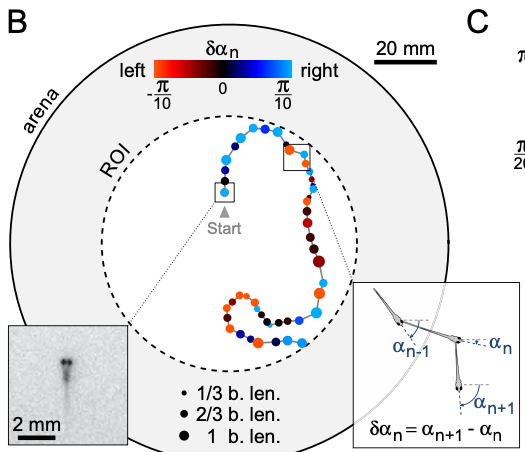

Distribution of bout angles, which decomposes as a mixture of two normal distributions with different amplitudes (given below), corresponding to "Forward" (F) bouts, and "Turning" bouts, for left (L) or right (R). Accordingly, we will below consider the bout angle emission distributions as Gaussian distributions.

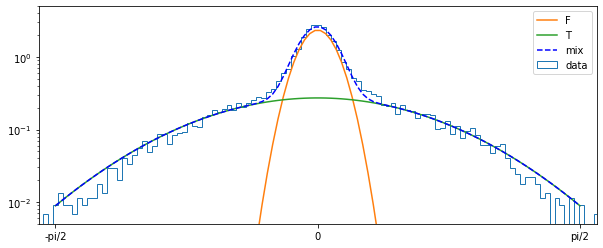

The transition probabilities matrix (rates are probs bc. time is discrete):

$$\begin{aligned}
\Omega &= \begin{pmatrix}
P(F\rightarrow F) & P(L\rightarrow F) & P(R\rightarrow F) \\
P(F\rightarrow L) & P(L\rightarrow L) & P(R\rightarrow L) \\
P(F\rightarrow R) & P(L\rightarrow R) & P(R\rightarrow R) \\
\end{pmatrix} \\
&= \begin{pmatrix}
1 - p_{turn} & 1 - p_{turn}         & 1 - p_{turn} \\
p_{turn}/2   & p_{turn}(1-p_{flip}) & p_{turn}p_{flip} \\
p_{turn}/2   & p_{turn}p_{flip}     & p_{turn}(1-p_{flip}) \\
\end{pmatrix}
\end{aligned}$$

where by symmetry considerations (left and right directions are equivalent in an unbiased walk):
$$P(F\rightarrow L) = P(F\rightarrow R) = p_{turn}/2$$
$$P(L\rightarrow R) = P(R\rightarrow L) = p_{turn}p_{flip}$$
We also assume that the decision to turn vs. forward bout is independent of the previous state.

To conclude the definition of the HMM, we need to specify how the states determine the probabilities of the bout angles. We assume normal distributions centered at 0. To model left and right bouts, we truncate these distributions to give positive or negative angles only, respectively:

$$E(\delta\alpha|F) = \mathscr{N}(\delta\alpha;\sigma_{F})$$
$$E(\delta\alpha|L) = \begin{cases}
2\mathscr{N}(\delta\alpha;\sigma_{T}) & \delta\alpha > 0 \\
0 & \delta\alpha \le 0
\end{cases}$$
$$E(\delta\alpha|R) = \begin{cases}
2\mathscr{N}(\delta\alpha;\sigma_{T}) & \delta\alpha < 0 \\
0 & \delta\alpha \ge 0
\end{cases}$$

where
$$\mathscr{N}(x;\sigma)=\frac{1}{\sqrt{ 2\pi\sigma^2 }} e^{ -\frac{1}{2}\frac{x^2}{\sigma^2}}$$
is the normal distribution of zero mean.

We will use the following values (determined by Karpenko et al): $\sigma_F=0.1$, $\sigma_T=0.6$, $p_{flip}=0.19$, $p_{turn}=0.41$.

## Questions

1. Show that $\Omega$ has an eigenvalue = 1, with corresponding eigenvector given by: $(1-p_{turn}, p_{turn}/2, p_{turn}/2)$.
2. Program the Viterbi algorithm to estimate, for one trajectory, the most likely path of hidden states. Then plot the first and second trajectory (`traj_0` and `traj_1` below) bout angles from the data in time, annotating the hidden state inferred by your algorithm for each time step.
3. (BONUS) Show that the marginal distribution of bout angles converges for long times to the Gaussian mixture:
$$P_{\infty}(\delta\alpha) = (1-p_{turn})\mathscr{N}(\delta\alpha;\sigma_{F}) + p_{turn}\mathscr{N}(\delta\alpha;\sigma_{T})$$

## References
* Karpenko, Sophia, et al. "From behavior to circuit modeling of light-seeking navigation in zebrafish larvae." _Elife_ 9 (2020): e52882.

In [3]:
# bout delta-angles are the difference between angle at time 't' and at time 't-1'
delta_alphas = alphas_spontaneous[1:,:] - alphas_spontaneous[:-1,:]

# trajectories we will use
traj_0 = delta_alphas[:14,0]
traj_1 = delta_alphas[:30,1]

In [4]:
p_flip = 0.19 # TL -> TR, TR -> TL
p_turn = 0.41
sigma_F = 0.1 # forward bout amplitude
sigma_T = 0.6 # turning bout amplitude

# transition matrix
omega = np.array([
    [1 - p_turn,  1 - p_turn,            1 - p_turn],
    [p_turn/2,    p_turn * (1 - p_flip), p_turn * p_flip],
    [p_turn/2,    p_turn * p_flip,       p_turn * (1 - p_flip)]
  ])

# equilibrium distribution of hidden states
p_eq = np.array([1 - p_turn, p_turn/2, p_turn/2])

In [5]:
def prob_normal(x, sigma):
  sigma2 = sigma**2
  return np.exp(-x**2 / sigma2 / 2) / np.sqrt(2 * np.pi * sigma2)

In [6]:
# compute emission probabilities from the 3 states, F, L, R
def hmm_emit_probs(data, sigma_F, sigma_T):
  prob_F = prob_normal(data, sigma_F)
  prob_L = np.where(data > 0, prob_normal(data, sigma_T) * 2, 1e-20)
  prob_R = np.where(data < 0, prob_normal(data, sigma_T) * 2, 1e-20)

  # nan data points denote missing measurements
  # We set P(NaN) = 1 for missing data, which means we don't consider these data points
  prob_F = np.where(np.isnan(prob_F), 1, prob_F)
  prob_L = np.where(np.isnan(prob_L), 1, prob_L)
  prob_R = np.where(np.isnan(prob_R), 1, prob_R)

  return np.stack((prob_F, prob_L, prob_R), axis=-1)

In [7]:
def viterbi(data):
    # put here the Viterbi algorithm code
    #Forward Propagation Viterbi Algorithm
    #find x(i) and lp(i) by maximising over the two hidden states in i+1
    #value of the loglikelihood maximised over all hidden units except the ith-hidden state
    #initial state the equilibrium distribution for the vp
    
    L=np.size(data)
    E=np.zeros((3,L))
    E[0,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,0]
    E[1,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,1]
    E[2,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,2]
    r=omega.T

    vp=np.zeros(3)
    vp=np.log(p_eq)
    vptmp=np.zeros(3)
    xp=np.zeros((L,3)).astype(int)
    for i in range (L-1):
        for x in range(3):
            lp=vp+np.log(E[:,i])+np.log(r[:,x])
            vptmp[x]=np.amax(lp)
            xp[i,x]=np.argmax(lp)
        vp=np.copy(vptmp)
    #overall log-prob of the sequence
    lp=vp+np.log(E[:,L-1])
    vplast=np.amax(lp)
    xf=np.zeros(L).astype(int)
    #most probable hidden variable for the last base
    xf[L-1]=np.argmax(lp)
    #Backpropagation to find the most probable sequence of hidden states
    for i in range(L-2,-1,-1):
        xf[i]=xp[i,xf[i+1]]


    return xf

Question 1 : plot the equilibrium of a change of angles from - pi/2 to pi/2

In [8]:
p_eq

array([0.59 , 0.205, 0.205])

Text(0, 0.5, 'Probability')

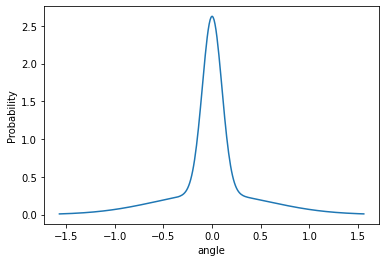

In [9]:
x=np.arange(-1.57,1.57,0.01)
d=np.size(x)
probx=np.zeros(d)

for i in range (d):
    probx[i]=(hmm_emit_probs(x[i], sigma_F, sigma_T)[0])*p_eq[0]+(hmm_emit_probs(x[i], sigma_F, sigma_T)[1])*p_eq[1]+ (hmm_emit_probs(x[i], sigma_F, sigma_T)[2])*p_eq[2]

plt.plot(x[:],probx[:])    
plt.xlabel("angle")
plt.ylabel("Probability")



In [10]:
np.sum(probx)*0.01

0.9963588408881553

Question 2 : plot the two trajectories and their normalized histogram comparing with the theoretical distribution

In [11]:
traj_0

array([-0.05964375, -0.02205352,  0.05464372, -0.27109047,  0.18177256,
        0.189435  , -0.03604658,  0.19053418, -0.0104957 ,  0.03036824,
        0.03001934,  0.1680665 ,  0.44189421, -0.04178945])

Text(0, 0.5, 'angle')

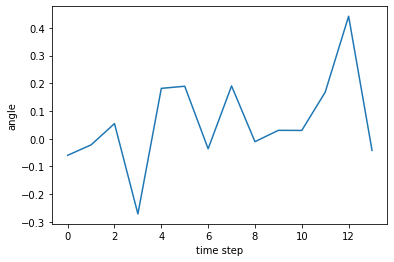

In [12]:
#Plot the two ftajectories and their histogtams and super pose with the sum of the emission probability
plt.plot(traj_0)
plt.xlabel("time step")
plt.ylabel("angle")


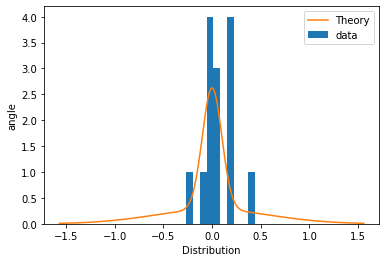

In [13]:
plt.hist(traj_0,label='data')
plt.plot(x[:],probx[:],label='Theory') 
plt.xlabel("Distribution")
plt.ylabel("angle")
plt.legend()
plt.show()

Text(0, 0.5, 'angle')

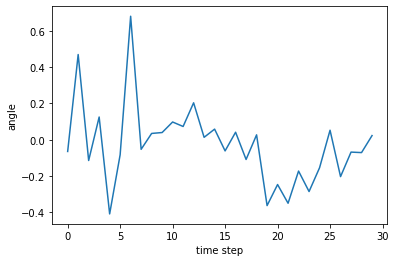

In [14]:
plt.plot(traj_1)
plt.xlabel("time step")
plt.ylabel("angle")


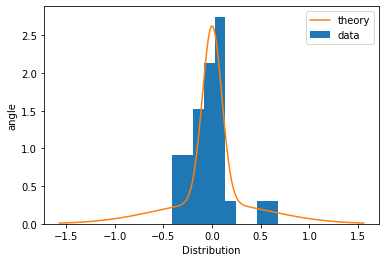

In [15]:
plt.hist(traj_1,density='true',label='data')
plt.plot(x[:],probx[:],label='theory')  
plt.xlabel("Distribution")
plt.ylabel("angle")
plt.legend()
plt.show()

# Viterbi on traj 1

In [16]:
#For each time step

data=traj_1
L=np.size(data)
E=np.zeros((3,L))
E[0,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,0]
E[1,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,1]
E[2,:]=hmm_emit_probs(data, sigma_F, sigma_T)[:,2]

r=omega

In [17]:
hmm_emit_probs(data, sigma_F, sigma_T)[0]

array([3.22781519e+00, 1.00000000e-20, 1.32200536e+00])

In [18]:
xf=viterbi(traj_1)

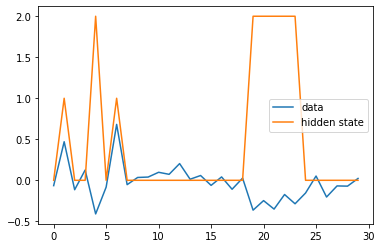

In [19]:
plt.plot(traj_1,label='data')
plt.plot(xf,label='hidden state')
#here 0,1,2 correspond to the hidden states F,L,R
plt.legend()
plt.show()

# Viterbi on Trajectory 0

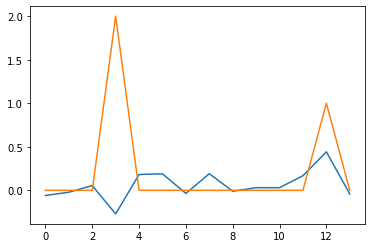

In [46]:
xf0=viterbi(traj_0)
plt.plot(traj_0,label='data')
plt.plot(xf0,label='hidden state')
#here 0,1,2 correspond to the hidden states F,L,R